Eugene Pashkovsky, practice 2

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

spark = SparkSession.builder.appName("DiabetesClassification").getOrCreate()

data = spark.read.csv("./dataset/diabetes_binary_health_indicators_BRFSS2015.csv", header=True, inferSchema=True)

feature_columns = data.columns[1:]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data).select("features", "Diabetes_binary")

train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

In [ ]:
lr = LogisticRegression(labelCol="Diabetes_binary", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Diabetes_binary", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="Diabetes_binary", metricName="accuracy")
evaluator_auc = BinaryClassificationEvaluator(labelCol="Diabetes_binary", metricName="areaUnderROC")

paramGrid_lr = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1]).build()
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_f1, numFolds=5, seed=123)
cv_lr_model = cv_lr.fit(train_data)
cv_lr_model.bestModel.getParam("regParam")

lr_predictions = cv_lr_model.transform(test_data)

f1_lr = evaluator_f1.evaluate(lr_predictions)
acc_lr = evaluator_acc.evaluate(lr_predictions)
auc_lr = evaluator_auc.evaluate(lr_predictions)

print(f"Logistic Regression - F1 Score: {f1_lr}, Accuracy: {acc_lr}, AUC: {auc_lr}")

paramGrid_dt = ParamGridBuilder().build()
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_f1, numFolds=5, seed=123)
cv_dt_model = cv_dt.fit(train_data)
dt_predictions = cv_dt_model.transform(test_data)

f1_dt = evaluator_f1.evaluate(dt_predictions)
acc_dt = evaluator_acc.evaluate(dt_predictions)
auc_dt = evaluator_auc.evaluate(dt_predictions)

print(f"Decision Tree - F1 Score: {f1_dt}, Accuracy: {acc_dt}, AUC: {auc_dt}")

print(f"Best Decision Tree Params: maxDepth={cv_dt_model.bestModel._java_obj.getMaxDepth()}, minInstancesPerNode={cv_dt_model.bestModel._java_obj.getMinInstancesPerNode()}")

# dt_roc_data = dt_predictions.select("Diabetes_binary", "probability").rdd.map(lambda row: (float(row["Diabetes_binary"]), float(row["probability"][1])))
# dt_roc_df = spark.createDataFrame(dt_roc_data, ["label", "score"])

# lr_roc_data = lr_predictions.select("Diabetes_binary", "probability").rdd.map(lambda row: (float(row["Diabetes_binary"]), float(row["probability"][1])))
# lr_roc_df = spark.createDataFrame(lr_roc_data, ["label", "score"])

# y_true_dt = [row["label"] for row in dt_roc_df.collect()]
# y_scores_dt = [row["score"] for row in dt_roc_df.collect()]

# y_true_lr = [row["label"] for row in lr_roc_df.collect()]
# y_scores_lr = [row["score"] for row in lr_roc_df.collect()]

# fpr_dt, tpr_dt, _ = roc_curve(y_true_dt, y_scores_dt)
# roc_auc_dt = auc(fpr_dt, tpr_dt)

# fpr_lr, tpr_lr, _ = roc_curve(y_true_lr, y_scores_lr)
# roc_auc_lr = auc(fpr_lr, tpr_lr)

# plt.figure(figsize=(10, 8))
# plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})", color='blue')
# plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})", color='green')
# plt.plot([0, 1], [0, 1], 'r--')

# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for Decision Tree and Logistic Regression")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


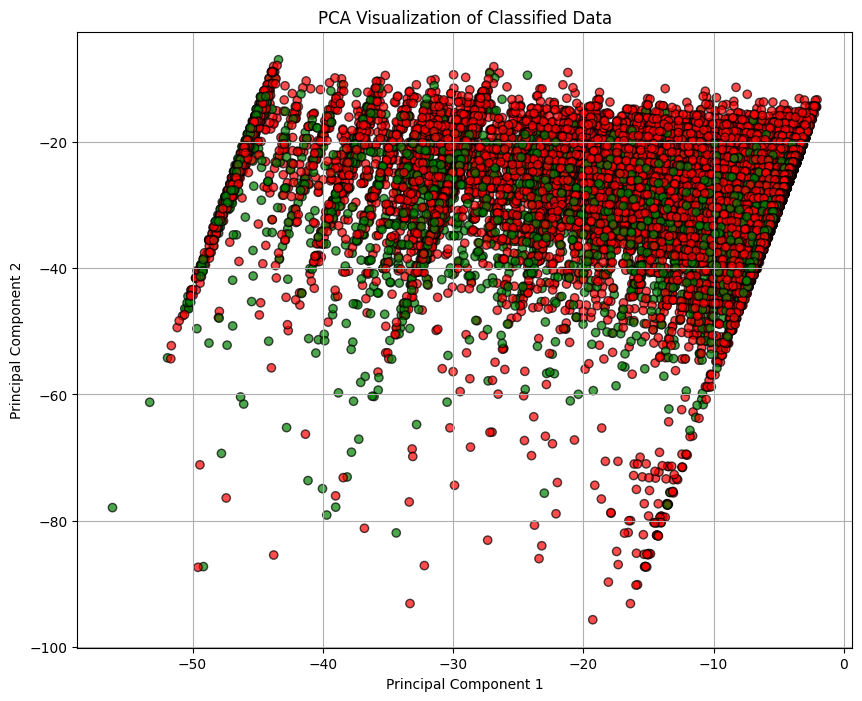

In [0]:
from pyspark.ml.feature import PCA
import numpy as np

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(test_data)
test_data_pca = pca_model.transform(test_data)

pca_data = test_data_pca.select("pcaFeatures", "Diabetes_binary").rdd.map(
    lambda row: (row["pcaFeatures"][0], row["pcaFeatures"][1], row["Diabetes_binary"])
).collect()

x = [point[0] for point in pca_data]
y = [point[1] for point in pca_data]
labels = [int(point[2]) for point in pca_data]

plt.figure(figsize=(10, 8))
colors = np.array(['red', 'green'])
plt.scatter(x, y, c=colors[labels], alpha=0.7, edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Classified Data")
plt.grid(True)
plt.show()


In [14]:
lr = LogisticRegression(labelCol="Diabetes_binary", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Diabetes_binary", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="Diabetes_binary", metricName="accuracy")
evaluator_auc = BinaryClassificationEvaluator(labelCol="Diabetes_binary", metricName="areaUnderROC")

paramGrid_lr = ParamGridBuilder() \
  .addGrid(lr.regParam, [1e-3, 1e-2, 0.01, 0.1, 1]) \
  .build()
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_auc, numFolds=5, seed=123)
cv_lr_model = cv_lr.fit(train_data)
lr_predictions = cv_lr_model.transform(test_data)

f1_lr = evaluator_f1.evaluate(lr_predictions)
acc_lr = evaluator_acc.evaluate(lr_predictions)
auc_lr = evaluator_auc.evaluate(lr_predictions)

print(f"Logistic Regression - F1 Score: {f1_lr}, Accuracy: {acc_lr}, AUC: {auc_lr}")

paramGrid_dt = ParamGridBuilder() \
  .addGrid(dt.maxDepth, [4, 6, 8, 16]) \
  .addGrid(dt.maxBins, [10, 25, 50, 100, 200]) \
  .addGrid(dt.minInstancesPerNode, [1, 2, 3]) \
  .build()
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_auc, numFolds=5, seed=123)
cv_dt_model = cv_dt.fit(train_data)
dt_predictions = cv_dt_model.transform(test_data)

f1_dt = evaluator_f1.evaluate(dt_predictions)
acc_dt = evaluator_acc.evaluate(dt_predictions)
auc_dt = evaluator_auc.evaluate(dt_predictions)

print(f"Decision Tree - F1 Score: {f1_dt}, Accuracy: {acc_dt}, AUC: {auc_dt}")

print(f"Best Logistic Regression Params: regParam={cv_lr_model.bestModel._java_obj.getRegParam()}")
print(f"Best Decision Tree Params: maxDepth={cv_dt_model.bestModel._java_obj.getMaxDepth()}, maxBins={cv_dt_model.bestModel._java_obj.getMaxBins()}, minInstancesPerNode={cv_dt_model.bestModel._java_obj.getMinInstancesPerNode()}")

# dt_roc_data = dt_predictions.select("Diabetes_binary", "probability").rdd.map(lambda row: (float(row["Diabetes_binary"]), float(row["probability"][1])))
# dt_roc_df = spark.createDataFrame(dt_roc_data, ["label", "score"])

# lr_roc_data = lr_predictions.select("Diabetes_binary", "probability").rdd.map(lambda row: (float(row["Diabetes_binary"]), float(row["probability"][1])))
# lr_roc_df = spark.createDataFrame(lr_roc_data, ["label", "score"])

# y_true_dt = [row["label"] for row in dt_roc_df.collect()]
# y_scores_dt = [row["score"] for row in dt_roc_df.collect()]

# y_true_lr = [row["label"] for row in lr_roc_df.collect()]
# y_scores_lr = [row["score"] for row in lr_roc_df.collect()]

# fpr_dt, tpr_dt, _ = roc_curve(y_true_dt, y_scores_dt)
# roc_auc_dt = auc(fpr_dt, tpr_dt)

# fpr_lr, tpr_lr, _ = roc_curve(y_true_lr, y_scores_lr)
# roc_auc_lr = auc(fpr_lr, tpr_lr)

# plt.figure(figsize=(10, 8))
# plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})", color='blue')
# plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})", color='green')
# plt.plot([0, 1], [0, 1], 'r--')

# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for Decision Tree and Logistic Regression")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


Logistic Regression - F1 Score: 0.8281759549236867, Accuracy: 0.8624313445561438, AUC: 0.8231270097949334
Decision Tree - F1 Score: 0.8240771214517204, Accuracy: 0.8623520314080066, AUC: 0.6070325933526218
Best Logistic Regression Params: regParam=0.001
Best Decision Tree Params: maxDepth=8, maxBins=50, minInstancesPerNode=1


In [0]:
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

data = spark.read.csv("/FileStore/tables/diabetes_binary_health_indicators_BRFSS2015.csv", header=True, inferSchema=True)

from pyspark.ml.feature import VectorAssembler
features = data.columns[1:]

vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
data_vectorized = vector_assembler.transform(data)

kmeans = KMeans(featuresCol="features", k=2, seed=14954244)
kmeans_model = kmeans.fit(data_vectorized)
kmeans_predictions = kmeans_model.transform(data_vectorized)

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
silhouette_kmeans = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette Score for K-means: {silhouette_kmeans}")

gmm = GaussianMixture(featuresCol="features", k=2, seed=14954244)
gmm_model = gmm.fit(data_vectorized)
gmm_predictions = gmm_model.transform(data_vectorized)

silhouette_gmm = evaluator.evaluate(gmm_predictions)
print(f"Silhouette Score for GMM: {silhouette_gmm}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Silhouette Score for K-means: 0.7708792253073055


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Silhouette Score for GMM: 0.42129428383319006


In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans, GaussianMixture

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")

kmeans = KMeans(featuresCol="features", seed=14954244)

kmeans_param_grid = (ParamGridBuilder()
                     .addGrid(kmeans.k, [2, 3, 4])
                     .addGrid(kmeans.maxIter, [10, 20])
                     .build())

kmeans_cv = CrossValidator(estimator=kmeans,
                           estimatorParamMaps=kmeans_param_grid,
                           evaluator=evaluator,
                           numFolds=5)

kmeans_model_cv = kmeans_cv.fit(data_vectorized)

kmeans_best_model = kmeans_model_cv.bestModel

print(f"Best KMeans Model Parameters:")
print(f"Number of clusters (k): {kmeans_best_model.getK()}")
print(f"Max iterations (maxIter): {kmeans_best_model.getMaxIter()}")

kmeans_predictions = kmeans_best_model.transform(data_vectorized)

silhouette_kmeans = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette Score for best KMeans model: {silhouette_kmeans}")

gmm = GaussianMixture(featuresCol="features", seed=14954244)

gmm_param_grid = (ParamGridBuilder()
                  .addGrid(gmm.k, [2, 3])
                  .addGrid(gmm.maxIter, [20, 30])
                  .addGrid(gmm.tol, [0.1, 0.5, 1])
                  .build())

gmm_cv = CrossValidator(estimator=gmm,
                        estimatorParamMaps=gmm_param_grid,
                        evaluator=evaluator,
                        numFolds=5)

gmm_model_cv = gmm_cv.fit(data_vectorized)

gmm_best_model = gmm_model_cv.bestModel

print(f"Best Gaussian Mixture Model Parameters:")
print(f"Number of components (k): {gmm_best_model.getK()}")
print(f"Max iterations (maxIter): {gmm_best_model.getMaxIter()}")
print(f"Convergence tolerance (tol): {gmm_best_model.getTol()}")

gmm_predictions = gmm_best_model.transform(data_vectorized)

silhouette_gmm = evaluator.evaluate(gmm_predictions)
print(f"Silhouette Score for best GMM model: {silhouette_gmm}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Best KMeans Model Parameters:
Number of clusters (k): 2
Max iterations (maxIter): 20
Silhouette Score for best KMeans model: 0.7708792253073055
Best Gaussian Mixture Model Parameters:
Number of components (k): 2
Max iterations (maxIter): 20
Convergence tolerance (tol): 0.01
Silhouette Score for best GMM model: 0.42129428383319006


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

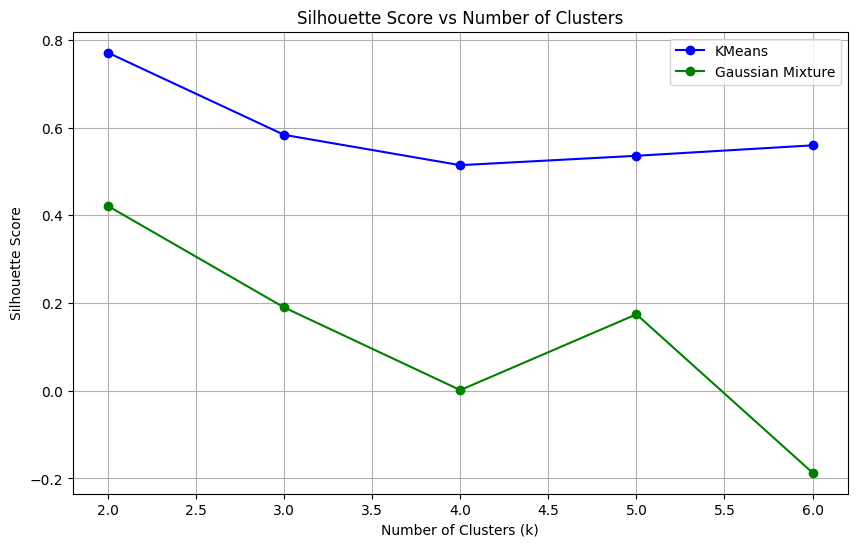

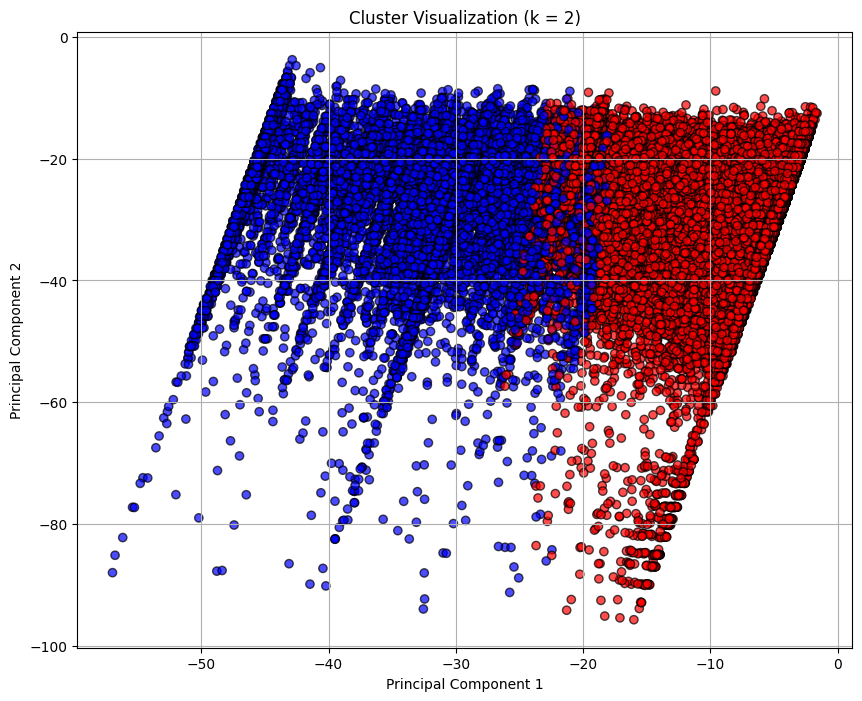

In [0]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np

k_values = [2, 3, 4, 5, 6]
silhouette_scores_kmeans = []
silhouette_scores_gmm = []

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=14954244)
    kmeans_model = kmeans.fit(data_vectorized)
    kmeans_predictions = kmeans_model.transform(data_vectorized)
    silhouette_kmeans = evaluator.evaluate(kmeans_predictions)
    silhouette_scores_kmeans.append(silhouette_kmeans)

    gmm = GaussianMixture(featuresCol="features", k=k, seed=14954244)
    gmm_model = gmm.fit(data_vectorized)
    gmm_predictions = gmm_model.transform(data_vectorized)
    silhouette_gmm = evaluator.evaluate(gmm_predictions)
    silhouette_scores_gmm.append(silhouette_gmm)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores_kmeans, marker='o', label='KMeans', color='blue')
plt.plot(k_values, silhouette_scores_gmm, marker='o', label='Gaussian Mixture', color='green')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

best_kmeans_predictions = kmeans_best_model.transform(data_vectorized)
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(best_kmeans_predictions)
pca_data = pca_model.transform(best_kmeans_predictions)

pca_points = pca_data.select("pcaFeatures", "prediction").rdd.map(
    lambda row: (row["pcaFeatures"][0], row["pcaFeatures"][1], row["prediction"])
).collect()

x = [point[0] for point in pca_points]
y = [point[1] for point in pca_points]
labels = [point[2] for point in pca_points]

plt.figure(figsize=(10, 8))
colors = np.array(['red', 'blue', 'green', 'purple', 'orange', 'cyan'])
plt.scatter(x, y, c=colors[labels], alpha=0.7, edgecolors='k')
plt.title(f"Cluster Visualization (k = {kmeans_best_model.getK()})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
